In [1]:
import tensorflow as tf

# Check to confirm that GPU is available
device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError ('GPU device not found')

print('Found GPU at: {}'.format(device_name))



Found GPU at: /device:GPU:0


In [4]:
# install pytorch_pretrained_bert the previous version of Pytorch-Transformers
#!pip install pytorch-pretrained-bert

     |████████████████████████████████| 123 kB 5.8 MB/s 
     |████████████████████████████████| 132 kB 12.0 MB/s 
     |████████████████████████████████| 8.6 MB 12.8 MB/s 
     |████████████████████████████████| 79 kB 11.2 MB/s 
     |████████████████████████████████| 138 kB 74.8 MB/s 
     |████████████████████████████████| 127 kB 52.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm , trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Check to confirm the specific GPU model
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [4]:
df_all = pd.read_csv ('train.tsv', delimiter='\t', header=None, encoding='cp850',
                  names=['text', 'label'])

df_all.shape

df_all[:3]

df = df_all[:10000]
df_valid = df_all[-10000:]

In [5]:
#df = df[:20000]
sentences = df.text.values
sentences = ["[CLS]" + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [6]:
# Tokenize Inputs

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case = True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print("Tokenize version of the the first sentence:")
print(tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 884548.54B/s]


Tokenize version of the the first sentence:
['[', 'cl', '##s', ']', 'en', 'route', ',', 'they', 'pick', 'up', 'a', 'seemingly', '-', 'harmless', 'hitch', '##hi', '##ker', ',', 'and', 'continue', 'their', 'journey', ',', 'only', 'for', 'their', 'car', 'to', 'break', 'down', 'in', 'a', 'deserted', 'motel', 'on', 'a', 'lonely', 'highway', '.', '[SEP]']


In [7]:
# Padding Sentences
# Set the maximum sequence length. The longest sequence in our training set
# is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128 

# Pad our input tokens
input_ids = pad_sequences(
    [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts], 
    maxlen=MAX_LEN, dtype="long", truncating="post", padding="post"
    )

# Index Numbers and Padding
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# pad sentences
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype ="long", truncating="post",padding ="post")


In [8]:
# Attention masks

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i > 0) for i in seq]
  attention_masks.append(seq_mask)


In [9]:
# Train and Validation Set

train_inputs, validation_inputs, train_labels, validation_labels = \
  train_test_split(input_ids, labels, random_state=2018, test_size=0.1)

train_masks, validation_masks , _, _ = \
  train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)
  
# transform all data into torch tensors

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [10]:
# Preparation for Training

# Select a batch size for training. For fine tuning BERT on a
# specific task , BERT authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader
# This helps save on memory during training because, unlike a for loop, 
# with iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = \
  DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = \
  TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = \
  DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [11]:
# Load BertForSequenceClassification, the pretrained BERT model
# with a single linear classification layer on top

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                      num_labels=2)

model.cuda()

100%|██████████| 407873900/407873900 [00:10<00:00, 37809596.20B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [12]:
# Hyperparameters

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']

optimizer_grouped_parameters = [
    {
        'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.01
    },
    {
        'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 
        'weight_decay_rate': 0.00
    }
  ]

optimizer = BertAdam(optimizer_grouped_parameters, lr=2e-5, warmup=0.1)

t_total value of -1 results in schedule not being applied


In [13]:
# calculates the accuracy of our predictions vs labels

def flat_accuracy(preds, labels):
  pred_flat  = np.argmax(preds , axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat)/len(labels_flat)


In [14]:
def compare(preds1, preds2):
  pred1_flat  = np.argmax(preds1 , axis=1).flatten()
  pred2_flat  = np.argmax(preds2 , axis=1).flatten()
  #labels_flat = labels.flatten()
  return pred1_flat >= pred2_flat

In [15]:
# Training Loop

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3
# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  # Training
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask , b_labels = batch
    # Clear out the gradients (by default they accumulate)
    b_labels = b_labels.cuda().long()
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
# Validation
# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

# Tracking variables
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients,
  # ve memory and speede up validation
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids =None, attention_mask=b_input_mask)
    
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  tmp_eval_accuracy = flat_accuracy(logits, label_ids)
  eval_accuracy += tmp_eval_accuracy
  nb_eval_steps += 1

print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  next_m.mul_(beta1).add_(1 - beta1, grad)
Epoch:  33%|███▎      | 1/3 [02:17<04:34, 137.49s/it]

Train loss: 0.6330696995376696


Epoch:  67%|██████▋   | 2/3 [04:33<02:16, 136.67s/it]

Train loss: 0.45136501312467225


Epoch: 100%|██████████| 3/3 [06:49<00:00, 136.47s/it]

Train loss: 0.3067562893455756


Validation Accuracy: 0.7119140625


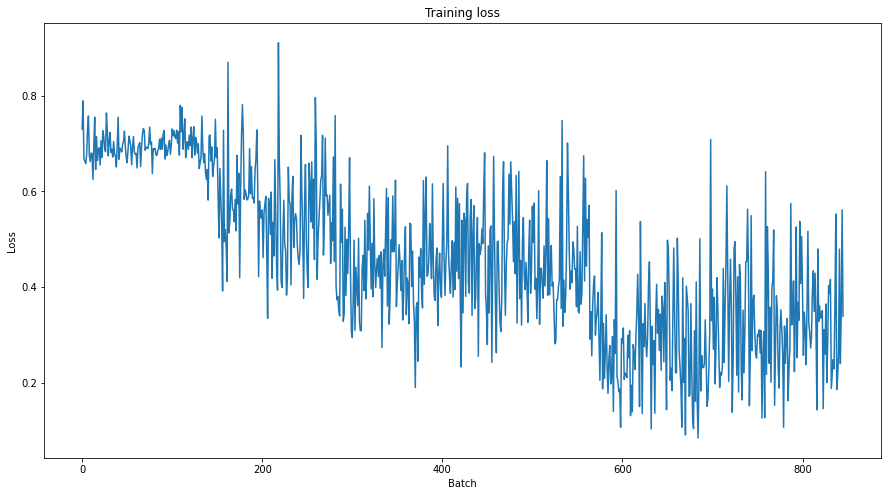

In [16]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
df_test = pd.read_csv("test.rand.txt", delimiter='\t', header=None, encoding='cp850', names=['text1', 'text2'])

# Create sentence) and label lists
sentences1 = df_test.text1.values
sentences2 = df_test.text2.values
# We need to add special tokens at the beginning and end of each sentence
# for BERT to work properly
sentences1 = ["[CLS] " + sentence1 + " [SEP]" for sentence1 in sentences1]
sentences2 = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences2]

tokenized_texts1 = [tokenizer.tokenize(sent1) for sent1 in sentences1]
tokenized_texts2 = [tokenizer.tokenize(sent2) for sent2 in sentences2]

print(tokenized_texts2)
# Padding Sentences
# Set the maximum sequence length. The longest sequence in our training set
# is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

input_ids1 = pad_sequences(
    [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts1], 
    maxlen=MAX_LEN, dtype="long", truncating="post", padding="post"
    )
input_ids2 = pad_sequences(
    [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts2], 
    maxlen=MAX_LEN, dtype="long", truncating="post", padding="post"
    )

# Index Numbers and Padding
input_ids1 = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts1]
input_ids2 = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts2]
# pad sentences
input_ids1 = pad_sequences(input_ids1, maxlen=MAX_LEN, 
                          dtype ="long", truncating="post",padding ="post")
input_ids2 = pad_sequences(input_ids2, maxlen=MAX_LEN, 
                          dtype ="long", truncating="post",padding ="post")
# Attention masks

# Create attention masks
attention_masks1 = []
attention_masks2 = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids1:
  seq_mask = [float(i > 0) for i in seq]
  attention_masks1.append(seq_mask)

for seq in input_ids2:
  seq_mask = [float(i > 0) for i in seq]
  attention_masks2.append(seq_mask)

prediction_inputs1 = torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)

prediction_inputs2 = torch.tensor(input_ids2)
prediction_masks2 = torch.tensor(attention_masks2)

batch_size = 32

prediction_data1 = \
  TensorDataset(prediction_inputs1, prediction_masks1)
prediction_sampler = SequentialSampler(prediction_data1)

prediction_dataloader1 = \
  DataLoader(prediction_data1, sampler=prediction_sampler, batch_size=batch_size)


prediction_data2 = \
  TensorDataset(prediction_inputs2, prediction_masks2)
prediction_sampler = SequentialSampler(prediction_data2)

prediction_dataloader2 = \
  DataLoader(prediction_data2, sampler=prediction_sampler, batch_size=batch_size)


In [19]:
# Prediction on the test set

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions1, predictions2 = [], []

# Predict
for batch in prediction_dataloader1:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids1, b_input_mask1 = batch
  # Telling the model not to compute or store gradients,
  # saving memory and speeding up prediction

  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits1 = model(b_input_ids1, token_type_ids=None, attention_mask=b_input_mask1)
  
  # Move logits and labels to CPU
  logits1 = logits1.detach().cpu().numpy()
  predictions1.append(logits1)

for batch in prediction_dataloader2:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids2, b_input_mask2 = batch
  # Telling the model not to compute or store gradients,
  # saving memory and speeding up prediction

  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits2 = model(b_input_ids2, token_type_ids=None, attention_mask=b_input_mask2)
  
  # Move logits and labels to CPU
  logits2 = logits2.detach().cpu().numpy()
  predictions2.append(logits2)
  

In [34]:
flat_predictions1 = [item for sublist in predictions1 for item in sublist]
flat_pred1 = np.argmax(flat_predictions1, axis=1).flatten()
flat_predictions2 = [item for sublist in predictions2 for item in sublist]
flat_pred2 = np.argmax(flat_predictions2, axis=1).flatten()
print(len(flat_predictions1))
print(len(flat_predictions2))
print(max(flat_predictions1[:][flat_pred1[0]]))
print(max(flat_predictions2[:][flat_pred2[0]]))
with open('part1.txt', 'a') as r: 
  for i in range(len(flat_predictions1)):
    if flat_pred1[i] > flat_pred2[i]:
      print("A", file=r)
    else:
      if max(flat_predictions1[:][flat_pred1[i]]) > max(flat_predictions2[:][flat_pred2[i]]) and flat_pred1[i] == flat_pred2[i]:
        print("A", file=r)
      else:
        print('B', file=r)

99866
99866
1.1602546
1.1602546
